# BT4222 Final Project

## COVID-19 Fake News Classifier

Prepared By: Group 13

Lee Sheng Hao Darren (A0201940U)

Loh Hong Tak Edmund (A0199943H)

Tan Yi Bing (A0204181U)

Teo Zhi Feng (A0203989N)

Yap Kai Herng (A0199729A)

In [1]:
GOOGLE_COLAB = False # If using Google Colab, set to true, else false.

## Importing Packages

In [1]:
# EDA
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import save,load
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import scipy
from scipy.stats import shapiro
from statistics import mean
from statistics import median
from statistics import variance

# NLP 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss, precision_score, recall_score, roc_auc_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans

import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

from gensim.models import Word2Vec
import gensim

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import utils, layers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Ensemble
import xgboost
from sklearn.ensemble import RandomForestClassifier

# Probabilistic 
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

# Online
from sklearn.linear_model import PassiveAggressiveClassifier


# Support
import re
import os
from collections import Counter
import logging
import time
import pickle
import itertools
import gc
from datetime import datetime


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\edmun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\edmun\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Settings

In [50]:
# SETTINGS

RANDOM_STATE = 42

# DATASET
TRAIN_SIZE = 0.8

#SETTINGS
RANDOM_STATE = 42

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# TENSORFLOW
SEQUENCE_LENGTH = 300
BATCH_SIZE = 128

gc.collect()

66

## Loading Datasets

In [51]:
train_ds = pd.read_csv("https://raw.githubusercontent.com/edologgerbird/BT4222_project/main/data/Constraint_Train.csv")
val_ds = pd.read_csv("https://raw.githubusercontent.com/edologgerbird/BT4222_project/main/data/Constraint_Val.csv")
df = pd.concat([train_ds,val_ds]).reset_index()

In [52]:
df.head()

,index,id,tweet,label
0,0,1,The CDC currently reports 99031 deaths. In gen...,real
1,1,2,States reported 1121 deaths a small rise from ...,real
2,2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,4,5,Populous states can generate large case counts...,real


In [53]:
df.label.unique()

array(['real', 'fake'], dtype=object)

In [54]:
df = df.drop('id', axis=1)

## Sanity Check




In this section, we check for:
1.   Null inputs
2.   Duplicated rows

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8560 entries, 0 to 8559
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   8560 non-null   int64 
 1   tweet   8560 non-null   object
 2   label   8560 non-null   object
dtypes: int64(1), object(2)
memory usage: 200.8+ KB


In [56]:
df.duplicated().sum()

0

In [57]:
df.label.value_counts()

real    4480
fake    4080
Name: label, dtype: int64

<AxesSubplot:>

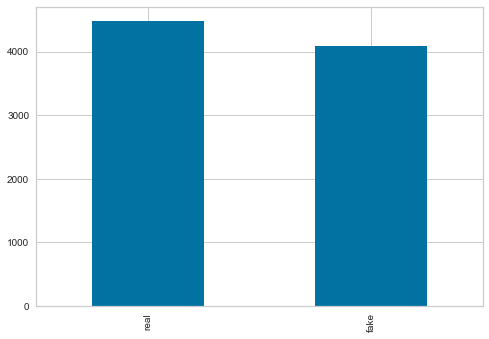

In [58]:
df.label.value_counts().plot(kind='bar')

## Data Pre-processing

In [59]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
lemmer = WordNetLemmatizer()

In [60]:
", ".join(stop_words)


"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

### Previewing Tweets

In [61]:
print(df.tweet.sample(15).values)

["@WndlB They said about a week ago they only had ~1000 ICU beds. But they've ramped up the capacity a lot over that time."
 'NEWS! Government finalising strategy to blame you for coronavirus deaths https://t.co/FtCa9H75OA https://t.co/yE55ETGpxz'
 'CDC’s symptom-based strategy offers an alternative to testing. https://t.co/WBMfTqle9k #covid19'
 'Images of BJP men smearing cow dung on one another after their party leader Suman Haripriya has said that cow dung may help cure Coronavirus.'
 'The battle against coronavirus is not over Matt Hancock says the number of patients in mechanical ventilator bed has risen above 100 for the first time since July and calls for the country to "come together against this common foe" Read more here: https://t.co/tG2cktJSKP https://t.co/hPs6gkeGLd'
 "If you maintain social distancing indoors there's no reason to have an additional mask on top of that."
 '_Claim that Indian prime minister Modi said one crore (ten million) COVID-19 infected patients have b

### Creating a column for word count

In [62]:
df['length'] = df['tweet'].apply(lambda x: len(x.split()))

### Preliminary Length Analysis

In [63]:
df['length'].describe()

count    8560.00000
mean       26.94778
std        22.45087
min         3.00000
25%        15.00000
50%        25.00000
75%        37.00000
max      1456.00000
Name: length, dtype: float64

<AxesSubplot:>

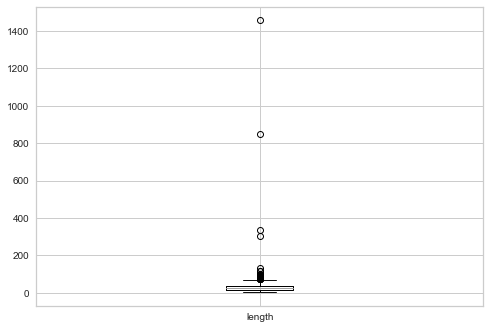

In [64]:
df.boxplot(column=['length'])

We notice outliers with extreme number of words. Previewing outlier articles here.

In [65]:
df[df['length']>150]

,index,tweet,label,length
270,270,"Amoxi"" Capsule made in US is the only medicine...",fake,1456
1109,1109,"Actors"" applauded Macron when he visited the s...",fake,847
6306,6306,Man visited Albany N.Y. days before dying from...,fake,336
8153,1733,I'm so happy that we’re able to do something v...,real,304


In [66]:
for tweet in df['tweet'][df['length']>150].values:
  print(tweet)

Amoxi" Capsule made in US is the only medicine that can completely cure COVID-19.
Egyptian Health Minister arrive in Italy with secret coronavirus cure.
 Dr Charles Lieber a Harvard professor has been arrested in the USA for manufacturing the coronavirus and selling it to China. A video news report from WCVB a TV station in Boston Massachusetts is shared with the Facebook post.
Mountain Matterhorn in Switzerland was lit in three colours of Indian flag as a token of gratitude to India for sending Hydroxychloroquine.
Al-Azhar Imam said he is considering exceptions on Ramadan fasting as the research says that the mouth must be kept wet to prevent COVID-19
 Japanese Nobel Tasuku Honjo says coronavirus was created in the Wuhan laboratory
A man collapses in 5 minutes after showing COVID-19 symptoms in India.
Celebrities spreading misinformation about coronavirus and the Janata curfew in India.
 Multiple posts shared repeatedly on Facebook and Twitter since March 2020 claim that Israel has re

We will remove the outlier articles to reduce noise when building our models.

In [67]:
df = df[df['length'] < 150]

(0.0, 200.0)

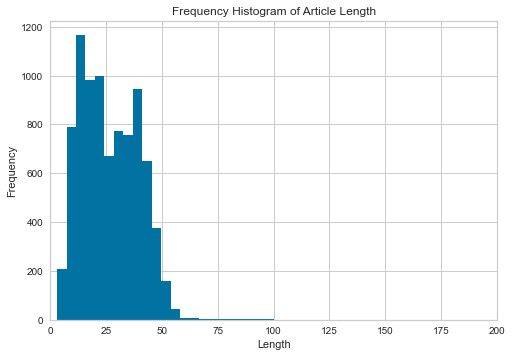

In [68]:
plt.hist(df['length'],bins=30)
plt.gca().set(title='Frequency Histogram of Article Length', ylabel='Frequency', xlabel='Length')
plt.xlim(0,200)


### Text Cleaning

- Transform to lowercase
- Remove trailing white spaces
- Remove stopwords
- Stem and lemmatize words to root form

In [69]:
TEXT_CLEANING_RE = "https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text):
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(lemmer.lemmatize(stemmer.stem(token)))
    return " ".join(tokens)

In [70]:
df.tweet = df.tweet.apply(lambda x:preprocess(x))

In [71]:
print(df.tweet.sample(15).values)

['news number plan made lockdown fall third day run'
 'coronavirus australia set lowest daili infect month say europ serv warn'
 'news coronavirus agre stay shop 24th juli'
 'covid 19 death fortaleza brazil may 29'
 'jedward say believ coronavirus start lose power'
 'covid 19 mean certif identif vaccin artifici intellig'
 'imag food distribut isol center state kerala india'
 'heard contact trace sure use health depart prevent spread covid19 learn slowthespread'
 'hospit set fire nairobi peopl discov lot poison vaccin coronavirus sent usa'
 'barcodenz hi alert level 2 librari abl open'
 'indiafightscorona covid19 infect still remain concentr 10 state contribut 80 new case'
 'covid19nigeria updat measur ea lockdown phase 2 curfew 10pm 4am restrict open religi centr funer limit 20 peopl use latex glove non medic purpos close school bar gym cinema restaur amp nightclub'
 'five recov case report bring total number activ case 67 34 import case miq facil 33 communiti case'
 'news itali made w

## Exploratory Data Analysis

### Length Analysis

<AxesSubplot:title={'center':'length'}, xlabel='label'>

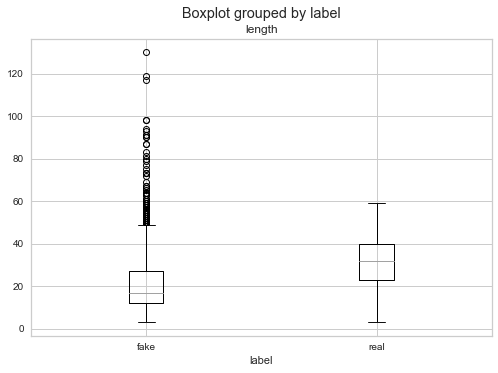

In [72]:
df.boxplot(column=["length"], by="label")

<AxesSubplot:xlabel='length', ylabel='Density'>

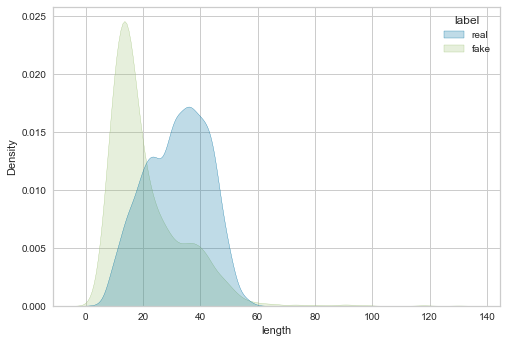

In [73]:
sns.kdeplot(data=df, x="length", hue="label", shade=True)

In [74]:
real = df["length"][df["label"]=="real"]
fake = df["length"][df["label"]=="fake"]


In [93]:
print(mean(real))
print(mean(fake))

31.684974324626033
21.048074564630856


In [89]:
print(scipy.stats.skew(fake))
print(scipy.stats.skew(real))

1.759677011339499
-0.1808558590317423


The length of fake news is highly right skewed

In [91]:
print(scipy.stats.kurtosis(fake))
print(scipy.stats.kurtosis(real))

5.620895453834617
-0.8023275139487924


The length of fake news has a very high kurtosis value, indicating a higher and sharper peak.

#### Hypothesis Tests on Article Length


H0: real = fake

H1: real > fake

Checking for normality. The low p-values indicate high departure from normality.

In [75]:
print(shapiro(real))
print(shapiro(fake))

ShapiroResult(statistic=0.9817632436752319, pvalue=1.3716072864927914e-23)
ShapiroResult(statistic=0.855253279209137, pvalue=0.0)


Checking for equality of variance. The low p-value indicates significant difference in variance.

In [41]:
scipy.stats.bartlett(real, fake)

BartlettResult(statistic=118.99478729814389, pvalue=1.0500508393955644e-27)

Since the two samples deviate significantly from the normal distribution, we use the non-parametric hypothesis test of two-samples Mann-Whitney U test. 

In [79]:
scipy.stats.mannwhitneyu(real, fake, use_continuity=True, alternative='greater')


MannwhitneyuResult(statistic=13915967.0, pvalue=0.0)

The P-value of the Mann-Whitney U test is 0.0. This means that the length of real news is significantly longer than that of fake news. 

### Word Clouds

#### Setting word exclusions from our wordclouds

In [26]:
cloud_stop = set(STOPWORDS)
cloud_stop.update(["covid", "coronavirus", "case", "covid-19", "peopl", "covid19", "amp"])

In [27]:
def generate_wordcloud(text):
    wordcloud = WordCloud(stopwords=cloud_stop, background_color="white").generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

#### Word Cloud for ALL text

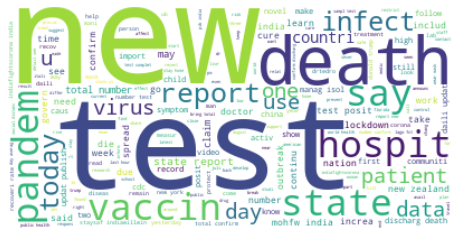

In [28]:
all_text = " ".join(tweet for tweet in df.tweet)
generate_wordcloud(all_text)

#### Word Cloud for Fake News

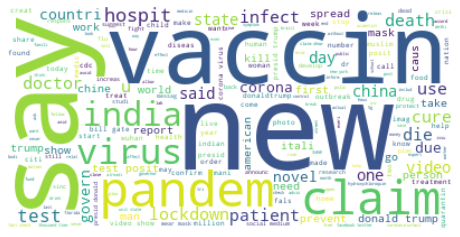

In [29]:
fake_text = " ".join(tweet for tweet in df[df['label']== 'fake'].tweet)
generate_wordcloud(fake_text)

#### Word Cloud for Real News

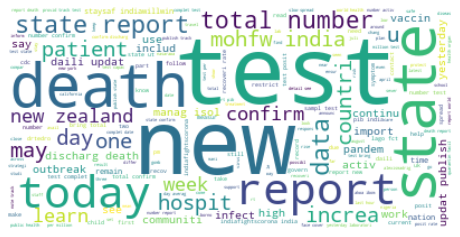

In [30]:
real_text = " ".join(tweet for tweet in df[df['label']== 'real'].tweet)
generate_wordcloud(real_text)

## Preparing Training and Testing Data

In [31]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=RANDOM_STATE)
print("TRAIN size: ", len(df_train))
print("TEST size: ", len(df_test))

TRAIN size:  6844
TEST size:  1712


### Label Encoding

In [32]:
encoder = LabelEncoder()
encoder.fit(df_train.label.tolist())

y_train  = encoder.transform(df_train.label.tolist())
y_test  = encoder.transform(df_test.label.tolist())

y_train  = y_train .reshape(-1,1)
y_test  = y_test.reshape(-1,1)

In [33]:
print("y_train", y_train.shape)
print("y_test", y_test.shape)

y_train (6844, 1)
y_test (1712, 1)


## Text Vectorisation Methods

### Count Vectorisation

In [34]:
count_vectorizer = CountVectorizer()
x_train_countv = count_vectorizer.fit_transform(df_train.tweet).astype(np.float64)
x_test_countv = count_vectorizer.transform(df_test.tweet).astype(np.float64)

#### Previewing Vocabulary

In [35]:
pd.DataFrame(count_vectorizer.vocabulary_, index=[0]).T

,0
nasser,7401
ziberi,11036
test,10015
posit,8212
covid,3796
...,...
danielleiwood,3974
bleak,2863
bankofamerica,2638
mandetta,6870


### TF-IDF Vectorisation

#### Vectorising Text Using TF-IDF Vectorizer

In [36]:
tfidf_vectorizer = TfidfVectorizer()
x_train_tfidf = tfidf_vectorizer.fit_transform(df_train.tweet)
x_test_tfidf = tfidf_vectorizer.transform(df_test.tweet)

#### Previewing Sparse TF-IDF Vector

In [37]:
train_tfidf_sklearn = pd.DataFrame(x_train_tfidf.toarray(),columns=tfidf_vectorizer.get_feature_names_out())
train_tfidf_sklearn.sort_index().round(decimals=5)
train_tfidf_sklearn 

,00,000,006,00ice,00pm,01,011,0141,02,03,...,zoo,zoodirector,zookeep,zoolog,zoom,zoonot,zuckoff,zurich,zydus,zyphr
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6839,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Previewing Words with Highest TFIDF Score

In [38]:
train_tfidf_sklearn = train_tfidf_sklearn.stack().reset_index()
train_tfidf_sklearn = train_tfidf_sklearn.rename(columns={0:'tfidf', 'level_0': 'id','level_1': 'term', 'level_2': 'term'})
train_tfidf_sklearn_sorted = train_tfidf_sklearn.sort_values(by=['id','tfidf'], ascending=[True,False]).groupby(['id'])


In [39]:
train_tfidf_sklearn_sorted.head(10)

,id,term,tfidf
7401,0,nasser,0.644215
11036,0,ziberi,0.644215
8212,0,posit,0.284045
10015,0,test,0.196617
488,0,19,0.164663
...,...,...,...
75656208,6843,00,0.000000
75656209,6843,000,0.000000
75656210,6843,006,0.000000
75656211,6843,00ice,0.000000


In [40]:
gc.collect()

0

### Word2Vec Model

#### Building Documents

In [41]:
documents = [tweet.split() for tweet in df_train.tweet]

#### Initialising word2vec model with hyperparameters

In [42]:
if GOOGLE_COLAB:
    w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                                window=W2V_WINDOW, 
                                                min_count=W2V_MIN_COUNT, 
                                                workers=8)
else:
    w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                                window=W2V_WINDOW, 
                                                min_count=W2V_MIN_COUNT, 
                                                workers=8)


#### Building Vocab

In [43]:
w2v_model.build_vocab(documents)

#### Training word2vec model

In [44]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

(2663656, 3787264)

In [45]:
w2v_model.wv.most_similar("covid")


[('coronaupd', 0.39213213324546814),
 ('diagnos', 0.32865211367607117),
 ('covid19india', 0.31867867708206177),
 ('covidupd', 0.3144167363643646),
 ('coronavirusindia', 0.3079738914966583),
 ('coronaviruspandem', 0.29463356733322144),
 ('suspect', 0.28586140275001526),
 ('certif', 0.2825537621974945),
 ('rash', 0.27986645698547363),
 ('drhvoffic', 0.27502942085266113)]

#### Tokenise Text

In [46]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.tweet)

vocab_size = len(tokenizer.word_index) + 1
print("Total unique words", vocab_size)

Total unique words 11088


#### Previewing top 20 words by Count

In [47]:
token_count = dict(tokenizer.word_counts)
token_count_df = pd.DataFrame(dict(sorted(token_count.items(), key=lambda item: item[1], reverse=True)),index=["Count"]).T
token_count_df.head(20)

,Count
covid,2538
case,2176
19,2137
test,1810
coronavirus,1706
covid19,1584
new,1163
report,1099
state,1095
death,870


#### Converting text to sequence of integers

In [48]:
x_train_word2vec = tokenizer.texts_to_sequences(df_train.tweet)
x_test_word2vec = tokenizer.texts_to_sequences(df_test.tweet)

#### Padding

In [49]:
x_train_word2vec  = pad_sequences(x_train_word2vec , maxlen=SEQUENCE_LENGTH)
x_test_word2vec  = pad_sequences(x_test_word2vec , maxlen=SEQUENCE_LENGTH)

#### Embedding Matrix

Populating matrix with weights

In [50]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(11088, 300)


## Model Building

In [51]:
training_data = [x_train_countv, x_train_tfidf, x_train_word2vec]
testing_data = [x_test_countv, x_test_tfidf, x_test_word2vec]

METRICS = ['accuracy', 'Precision','Recall','AUC']

CALLBACKS = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

EPOCHS = 12

results_store = {}

### Helper Functions

In [52]:
def get_results_store():
    return pd.DataFrame(results_store).T

def batch_generator(x, y, batch_size):
    samples_per_epoch = x.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y)[0])
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        x_batch = x[index_batch,:].toarray()
        y_batch = y[min(index_batch):max(index_batch)+1]
        counter += 1
        x_batch = np.expand_dims(x_batch, axis=2)
        yield x_batch, np.array(y_batch)
        if (counter > number_of_batches):
            counter=0

def get_F1(precision, recall):
    if precision == recall == 0:
        return 0
    return 2* (precision*recall)/(precision+recall)

def get_results(history):
    loss = history[0]
    accuracy = history[1]
    precision = history[2]
    recall = history[3]
    auc = history[4]
    F1 = get_F1(precision,recall)
    results ={
        "Loss": loss,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "AUC": auc,
        "F1 Score": F1
    }
    return results

def get_evaluation_vect(model, x_test, model_name, vectoriser, duration):
    name = model_name + " " + vectoriser
    x_test_DL = np.expand_dims(x_test.toarray(), axis=2)
    eval = model.evaluate(x_test_DL, y_test, batch_size=32)
    result = get_results(eval)
    result["time"] = duration.total_seconds()
    result["model"] = model_name
    result["vectoriser"] = vectoriser
    results_store[name] = result
    return result

def get_deep_learning_results_vect(model, model_name):
    gc.collect()
    model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=METRICS)
    
    #count_vectorizer
    print("\n >>> Training Count Vectorisation Model ========================================= \n")
    time_start = datetime.now()
    fit_countv = model.fit(
        batch_generator(x_train_countv, y_train, 32),
        epochs = EPOCHS,
        steps_per_epoch=x_train_countv.shape[0]/32
    )
    duration = datetime.now() - time_start
    result_countv = get_evaluation_vect(model, x_test_countv, model_name, "count", duration)
    print(result_countv)

    #tf-idf vectorizer
    print("\n >>> Training TFIDF Vectorisation Model ========================================= \n")
    time_start = datetime.now()
    fit_tfidf = model.fit(
        batch_generator(x_train_tfidf, y_train, 32),
        epochs = EPOCHS,
        steps_per_epoch=x_train_tfidf.shape[0]/32      
    )
    duration = datetime.now() - time_start
    result_tfidf = get_evaluation_vect(model, x_test_tfidf, model_name, "tfidf", duration)
    print(result_tfidf)

    
    return 

def get_evaluation_w2v(model, model_name, vectoriser, duration):
    name = model_name + " " + vectoriser
    eval = model.evaluate(x_test_word2vec , y_test , batch_size=BATCH_SIZE)
    result = get_results(eval)
    result["time"] = duration.total_seconds()
    result["model"] = model_name
    result["vectoriser"] = vectoriser
    results_store[name] = result
    return result

def get_deep_learning_results_w2v(model, model_name):
    gc.collect()
    model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=METRICS)
              
    print("\n >>> Training Word2Vec Model ========================================= \n")
    time_start = datetime.now()
    fit_word2vec = model.fit(
        x_train_word2vec , y_train ,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_split=0.1,
        verbose=1,
        callbacks=CALLBACKS
    )
    duration = datetime.now() - time_start
    result_word2vec = get_evaluation_w2v(model, model_name, "word2vec", duration)
    print(result_word2vec)
    return 

## Deep Learning Models

### TextCNN

In [53]:
cnn_vect_model = tf.keras.Sequential([
    layers.Conv1D(128, 5, activation='relu', input_shape=(None,1)),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

get_deep_learning_results_vect(cnn_vect_model, "CNN")



 >>> Training Count Vectorisation Model ========================================= 

Epoch 1/12
213/213 [==============================] - 20s 70ms/step - loss: 0.6372 - accuracy: 0.6401 - precision: 0.6329 - recall: 0.7549 - auc: 0.6955
Epoch 2/12
213/213 [==============================] - 15s 72ms/step - loss: 0.6198 - accuracy: 0.6771 - precision: 0.7022 - recall: 0.6722 - auc: 0.7003
Epoch 3/12
213/213 [==============================] - 16s 74ms/step - loss: 0.6189 - accuracy: 0.6790 - precision: 0.7026 - recall: 0.6775 - auc: 0.7012
Epoch 4/12
213/213 [==============================] - 16s 76ms/step - loss: 0.6184 - accuracy: 0.6793 - precision: 0.7026 - recall: 0.6786 - auc: 0.7015
Epoch 5/12
213/213 [==============================] - 17s 80ms/step - loss: 0.6181 - accuracy: 0.6791 - precision: 0.7025 - recall: 0.6783 - auc: 0.7012
Epoch 6/12
213/213 [==============================] - 17s 80ms/step - loss: 0.6180 - accuracy: 0.6793 - precision: 0.7027 - recall: 0.6783 - auc: 0.70

In [54]:
cnn_word2vec_model = tf.keras.Sequential([
    layers.Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False),
    layers. Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

get_deep_learning_results_w2v(cnn_word2vec_model, "CNN")


 >>> Training Word2Vec Model ========================================= 

Epoch 1/12
49/49 [==============================] - 4s 55ms/step - loss: 0.3050 - accuracy: 0.8646 - precision: 0.8602 - recall: 0.8858 - auc: 0.9430 - val_loss: 0.2451 - val_accuracy: 0.8832 - val_precision: 0.8874 - val_recall: 0.9016 - val_auc: 0.9640
Epoch 2/12
49/49 [==============================] - 2s 45ms/step - loss: 0.1836 - accuracy: 0.9273 - precision: 0.9380 - recall: 0.9223 - auc: 0.9786 - val_loss: 0.2357 - val_accuracy: 0.8934 - val_precision: 0.8997 - val_recall: 0.9069 - val_auc: 0.9680
Epoch 3/12
49/49 [==============================] - 2s 46ms/step - loss: 0.1282 - accuracy: 0.9573 - precision: 0.9711 - recall: 0.9467 - auc: 0.9901 - val_loss: 0.2178 - val_accuracy: 0.9066 - val_precision: 0.9239 - val_recall: 0.9043 - val_auc: 0.9718
Epoch 4/12
49/49 [==============================] - 2s 45ms/step - loss: 0.0894 - accuracy: 0.9740 - precision: 0.9851 - recall: 0.9650 - auc: 0.9956 - val_loss:

In [55]:
get_results_store()

,Loss,Accuracy,Precision,Recall,AUC,F1 Score,time,model,vectoriser
CNN count,0.593343,0.706776,0.723764,0.687285,0.738835,0.705053,208.74185,CNN,count
CNN tfidf,0.657568,0.613902,0.598696,0.736541,0.655878,0.660503,195.964399,CNN,tfidf
CNN word2vec,0.243096,0.921729,0.913774,0.934708,0.971479,0.924122,26.43114,CNN,word2vec


### LSTM (Unidirectional)

In [56]:
lstm_vect_model = tf.keras.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(None,1)),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

get_deep_learning_results_vect(lstm_vect_model, "LSTM")



 >>> Training Count Vectorisation Model ========================================= 

Epoch 1/12
213/213 [==============================] - 78s 354ms/step - loss: 0.6616 - accuracy: 0.5919 - precision: 0.5823 - recall: 0.7978 - auc: 0.6523
Epoch 2/12
213/213 [==============================] - 77s 358ms/step - loss: 0.6230 - accuracy: 0.6636 - precision: 0.6764 - recall: 0.6933 - auc: 0.7049
Epoch 3/12
213/213 [==============================] - 77s 358ms/step - loss: 0.6184 - accuracy: 0.6696 - precision: 0.6849 - recall: 0.6908 - auc: 0.7110
Epoch 4/12
213/213 [==============================] - 78s 364ms/step - loss: 0.6672 - accuracy: 0.5922 - precision: 0.5906 - recall: 0.7366 - auc: 0.6306
Epoch 5/12
213/213 [==============================] - 81s 378ms/step - loss: 0.6791 - accuracy: 0.5776 - precision: 0.5719 - recall: 0.7884 - auc: 0.6044
Epoch 6/12
213/213 [==============================] - 82s 383ms/step - loss: 0.6632 - accuracy: 0.6147 - precision: 0.6127 - recall: 0.7304 - auc

In [57]:
lstm_word2vec_model = tf.keras.Sequential([
    layers.Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False),
    layers.LSTM(64, return_sequences=True),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

get_deep_learning_results_w2v(lstm_word2vec_model, "LSTM")


 >>> Training Word2Vec Model ========================================= 

Epoch 1/12
49/49 [==============================] - 6s 68ms/step - loss: 0.3621 - accuracy: 0.8357 - precision: 0.8093 - recall: 0.8985 - auc: 0.9274 - val_loss: 0.2551 - val_accuracy: 0.8978 - val_precision: 0.9180 - val_recall: 0.8936 - val_auc: 0.9619
Epoch 2/12
49/49 [==============================] - 3s 55ms/step - loss: 0.2342 - accuracy: 0.9052 - precision: 0.9235 - recall: 0.8932 - auc: 0.9661 - val_loss: 0.2374 - val_accuracy: 0.8934 - val_precision: 0.8875 - val_recall: 0.9229 - val_auc: 0.9693
Epoch 3/12
49/49 [==============================] - 3s 59ms/step - loss: 0.2023 - accuracy: 0.9187 - precision: 0.9358 - recall: 0.9071 - auc: 0.9741 - val_loss: 0.2193 - val_accuracy: 0.9007 - val_precision: 0.9140 - val_recall: 0.9043 - val_auc: 0.9716
Epoch 4/12
49/49 [==============================] - 3s 60ms/step - loss: 0.1793 - accuracy: 0.9290 - precision: 0.9472 - recall: 0.9158 - auc: 0.9796 - val_loss:

In [58]:
get_results_store()

,Loss,Accuracy,Precision,Recall,AUC,F1 Score,time,model,vectoriser
CNN count,0.593343,0.706776,0.723764,0.687285,0.738835,0.705053,208.74185,CNN,count
CNN tfidf,0.657568,0.613902,0.598696,0.736541,0.655878,0.660503,195.964399,CNN,tfidf
CNN word2vec,0.243096,0.921729,0.913774,0.934708,0.971479,0.924122,26.43114,CNN,word2vec
LSTM count,0.59968,0.705023,0.72439,0.680412,0.731643,0.701713,956.086916,LSTM,count
LSTM tfidf,0.697467,0.50993,0.50993,1.0,0.617393,0.675435,1045.55275,LSTM,tfidf
LSTM word2vec,0.203131,0.930491,0.941452,0.920962,0.976768,0.931094,37.314343,LSTM,word2vec


### LSTM (Bidirectional)

In [59]:
bilstm_vect_model = tf.keras.Sequential([
    layers.Bidirectional(layers.LSTM(64, return_sequences=True, input_shape=(None,1))),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

get_deep_learning_results_vect(bilstm_vect_model, "BiLSTM")



 >>> Training Count Vectorisation Model ========================================= 

Epoch 1/12
213/213 [==============================] - 175s 801ms/step - loss: 0.6490 - accuracy: 0.6249 - precision: 0.6180 - recall: 0.7546 - auc: 0.6699
Epoch 2/12
213/213 [==============================] - 171s 798ms/step - loss: 0.6291 - accuracy: 0.6575 - precision: 0.6788 - recall: 0.6644 - auc: 0.6961
Epoch 3/12
213/213 [==============================] - 170s 796ms/step - loss: 0.6212 - accuracy: 0.6651 - precision: 0.6781 - recall: 0.6936 - auc: 0.7068
Epoch 4/12
213/213 [==============================] - 173s 810ms/step - loss: 0.6175 - accuracy: 0.6674 - precision: 0.6806 - recall: 0.6950 - auc: 0.7125
Epoch 5/12
213/213 [==============================] - 172s 807ms/step - loss: 0.6409 - accuracy: 0.6366 - precision: 0.6526 - recall: 0.6636 - auc: 0.6842
Epoch 6/12
213/213 [==============================] - 174s 813ms/step - loss: 0.6219 - accuracy: 0.6712 - precision: 0.6965 - recall: 0.6664

In [60]:
bilstm_word2vec_model = tf.keras.Sequential([
    layers.Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

get_deep_learning_results_w2v(bilstm_word2vec_model, "BiLSTM")


 >>> Training Word2Vec Model ========================================= 

Epoch 1/12
49/49 [==============================] - 10s 119ms/step - loss: 0.3346 - accuracy: 0.8557 - precision: 0.8368 - recall: 0.9003 - auc: 0.9369 - val_loss: 0.2409 - val_accuracy: 0.9007 - val_precision: 0.9254 - val_recall: 0.8910 - val_auc: 0.9656
Epoch 2/12
49/49 [==============================] - 5s 102ms/step - loss: 0.2131 - accuracy: 0.9165 - precision: 0.9273 - recall: 0.9124 - auc: 0.9718 - val_loss: 0.2172 - val_accuracy: 0.9080 - val_precision: 0.9196 - val_recall: 0.9122 - val_auc: 0.9718
Epoch 3/12
49/49 [==============================] - 5s 105ms/step - loss: 0.1867 - accuracy: 0.9274 - precision: 0.9410 - recall: 0.9192 - auc: 0.9782 - val_loss: 0.2064 - val_accuracy: 0.9109 - val_precision: 0.9339 - val_recall: 0.9016 - val_auc: 0.9739
Epoch 4/12
49/49 [==============================] - 5s 109ms/step - loss: 0.1653 - accuracy: 0.9334 - precision: 0.9471 - recall: 0.9248 - auc: 0.9826 - val_

In [61]:
get_results_store()

,Loss,Accuracy,Precision,Recall,AUC,F1 Score,time,model,vectoriser
CNN count,0.593343,0.706776,0.723764,0.687285,0.738835,0.705053,208.74185,CNN,count
CNN tfidf,0.657568,0.613902,0.598696,0.736541,0.655878,0.660503,195.964399,CNN,tfidf
CNN word2vec,0.243096,0.921729,0.913774,0.934708,0.971479,0.924122,26.43114,CNN,word2vec
LSTM count,0.59968,0.705023,0.72439,0.680412,0.731643,0.701713,956.086916,LSTM,count
LSTM tfidf,0.697467,0.50993,0.50993,1.0,0.617393,0.675435,1045.55275,LSTM,tfidf
LSTM word2vec,0.203131,0.930491,0.941452,0.920962,0.976768,0.931094,37.314343,LSTM,word2vec
BiLSTM count,0.593628,0.705607,0.718343,0.695304,0.758815,0.706636,2058.792981,BiLSTM,count
BiLSTM tfidf,0.653125,0.620911,0.605461,0.736541,0.663353,0.6646,1997.618818,BiLSTM,tfidf
BiLSTM word2vec,0.191646,0.932827,0.944836,0.922108,0.98079,0.933333,67.09726,BiLSTM,word2vec


### LSTM + CNN

In [62]:
lstmcnn_vect_model = tf.keras.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(None,1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

get_deep_learning_results_vect(lstmcnn_vect_model, "LSTM+CNN")


 >>> Training Count Vectorisation Model ========================================= 

Epoch 1/12
213/213 [==============================] - 95s 435ms/step - loss: 0.6364 - accuracy: 0.6428 - precision: 0.6401 - recall: 0.7354 - auc: 0.6892
Epoch 2/12
213/213 [==============================] - 93s 436ms/step - loss: 0.6174 - accuracy: 0.6672 - precision: 0.6871 - recall: 0.6761 - auc: 0.7113
Epoch 3/12
213/213 [==============================] - 93s 435ms/step - loss: 0.6144 - accuracy: 0.6707 - precision: 0.6965 - recall: 0.6644 - auc: 0.7155
Epoch 4/12
213/213 [==============================] - 93s 436ms/step - loss: 0.6125 - accuracy: 0.6755 - precision: 0.7035 - recall: 0.6639 - auc: 0.7179
Epoch 5/12
213/213 [==============================] - 93s 435ms/step - loss: 0.6109 - accuracy: 0.6769 - precision: 0.7064 - recall: 0.6620 - auc: 0.7205
Epoch 6/12
213/213 [==============================] - 94s 438ms/step - loss: 0.6090 - accuracy: 0.6797 - precision: 0.7062 - recall: 0.6714 - auc

In [63]:
lstmcnn_word2vec_model = tf.keras.Sequential([
    layers.Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False),
    layers.LSTM(64, return_sequences=True),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
            
get_deep_learning_results_w2v(lstmcnn_word2vec_model, "LSTM+CNN")


 >>> Training Word2Vec Model ========================================= 

Epoch 1/12
49/49 [==============================] - 6s 82ms/step - loss: 0.3253 - accuracy: 0.8557 - precision: 0.8520 - recall: 0.8771 - auc: 0.9352 - val_loss: 0.2560 - val_accuracy: 0.8920 - val_precision: 0.9290 - val_recall: 0.8697 - val_auc: 0.9611
Epoch 2/12
49/49 [==============================] - 3s 68ms/step - loss: 0.2110 - accuracy: 0.9139 - precision: 0.9352 - recall: 0.8981 - auc: 0.9716 - val_loss: 0.2361 - val_accuracy: 0.8964 - val_precision: 0.9472 - val_recall: 0.8590 - val_auc: 0.9695
Epoch 3/12
49/49 [==============================] - 3s 67ms/step - loss: 0.1862 - accuracy: 0.9253 - precision: 0.9485 - recall: 0.9068 - auc: 0.9774 - val_loss: 0.2547 - val_accuracy: 0.8876 - val_precision: 0.8655 - val_recall: 0.9415 - val_auc: 0.9727
Epoch 4/12
49/49 [==============================] - 3s 71ms/step - loss: 0.1641 - accuracy: 0.9370 - precision: 0.9528 - recall: 0.9257 - auc: 0.9825 - val_loss:

In [64]:
get_results_store()

,Loss,Accuracy,Precision,Recall,AUC,F1 Score,time,model,vectoriser
CNN count,0.593343,0.706776,0.723764,0.687285,0.738835,0.705053,208.74185,CNN,count
CNN tfidf,0.657568,0.613902,0.598696,0.736541,0.655878,0.660503,195.964399,CNN,tfidf
CNN word2vec,0.243096,0.921729,0.913774,0.934708,0.971479,0.924122,26.43114,CNN,word2vec
LSTM count,0.59968,0.705023,0.72439,0.680412,0.731643,0.701713,956.086916,LSTM,count
LSTM tfidf,0.697467,0.50993,0.50993,1.0,0.617393,0.675435,1045.55275,LSTM,tfidf
LSTM word2vec,0.203131,0.930491,0.941452,0.920962,0.976768,0.931094,37.314343,LSTM,word2vec
BiLSTM count,0.593628,0.705607,0.718343,0.695304,0.758815,0.706636,2058.792981,BiLSTM,count
BiLSTM tfidf,0.653125,0.620911,0.605461,0.736541,0.663353,0.6646,1997.618818,BiLSTM,tfidf
BiLSTM word2vec,0.191646,0.932827,0.944836,0.922108,0.98079,0.933333,67.09726,BiLSTM,word2vec
LSTM+CNN count,0.579105,0.712033,0.766106,0.626575,0.769024,0.689351,1120.574395,LSTM+CNN,count


### BiDirectional LSTM + CNN

In [65]:
bilstmcnn_vect_model = tf.keras.Sequential([
    layers.Bidirectional(layers.LSTM(64, return_sequences=True, input_shape=(None,1))),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

get_deep_learning_results_vect(bilstmcnn_vect_model, "BiLSTM+CNN")


 >>> Training Count Vectorisation Model ========================================= 

Epoch 1/12
213/213 [==============================] - 190s 874ms/step - loss: 0.6437 - accuracy: 0.6495 - precision: 0.6797 - recall: 0.6331 - auc: 0.6791
Epoch 2/12
213/213 [==============================] - 183s 854ms/step - loss: 0.6179 - accuracy: 0.6686 - precision: 0.6804 - recall: 0.6997 - auc: 0.7144
Epoch 3/12
213/213 [==============================] - 187s 873ms/step - loss: 0.6132 - accuracy: 0.6699 - precision: 0.6873 - recall: 0.6852 - auc: 0.7210
Epoch 4/12
213/213 [==============================] - 185s 863ms/step - loss: 0.6116 - accuracy: 0.6742 - precision: 0.7000 - recall: 0.6678 - auc: 0.7219
Epoch 5/12
213/213 [==============================] - 187s 874ms/step - loss: 0.6080 - accuracy: 0.6783 - precision: 0.7063 - recall: 0.6664 - auc: 0.7281
Epoch 6/12
213/213 [==============================] - 190s 891ms/step - loss: 0.6092 - accuracy: 0.6771 - precision: 0.7039 - recall: 0.6683

In [66]:
bilstmcnn_word2vec_model = tf.keras.Sequential([
    layers.Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
            
get_deep_learning_results_w2v(bilstmcnn_word2vec_model, "BiLSTM+CNN")


 >>> Training Word2Vec Model ========================================= 

Epoch 1/12
49/49 [==============================] - 9s 131ms/step - loss: 0.2959 - accuracy: 0.8803 - precision: 0.8966 - recall: 0.8724 - auc: 0.9460 - val_loss: 0.2489 - val_accuracy: 0.8818 - val_precision: 0.8734 - val_recall: 0.9176 - val_auc: 0.9664
Epoch 2/12
49/49 [==============================] - 6s 116ms/step - loss: 0.2023 - accuracy: 0.9170 - precision: 0.9282 - recall: 0.9124 - auc: 0.9741 - val_loss: 0.2161 - val_accuracy: 0.9036 - val_precision: 0.9354 - val_recall: 0.8856 - val_auc: 0.9727
Epoch 3/12
49/49 [==============================] - 6s 124ms/step - loss: 0.1670 - accuracy: 0.9316 - precision: 0.9489 - recall: 0.9192 - auc: 0.9824 - val_loss: 0.2105 - val_accuracy: 0.8993 - val_precision: 0.9229 - val_recall: 0.8910 - val_auc: 0.9748
Epoch 4/12
49/49 [==============================] - 6s 124ms/step - loss: 0.1381 - accuracy: 0.9453 - precision: 0.9614 - recall: 0.9331 - auc: 0.9877 - val_l

In [67]:
get_results_store()

,Loss,Accuracy,Precision,Recall,AUC,F1 Score,time,model,vectoriser
CNN count,0.593343,0.706776,0.723764,0.687285,0.738835,0.705053,208.74185,CNN,count
CNN tfidf,0.657568,0.613902,0.598696,0.736541,0.655878,0.660503,195.964399,CNN,tfidf
CNN word2vec,0.243096,0.921729,0.913774,0.934708,0.971479,0.924122,26.43114,CNN,word2vec
LSTM count,0.59968,0.705023,0.72439,0.680412,0.731643,0.701713,956.086916,LSTM,count
LSTM tfidf,0.697467,0.50993,0.50993,1.0,0.617393,0.675435,1045.55275,LSTM,tfidf
LSTM word2vec,0.203131,0.930491,0.941452,0.920962,0.976768,0.931094,37.314343,LSTM,word2vec
BiLSTM count,0.593628,0.705607,0.718343,0.695304,0.758815,0.706636,2058.792981,BiLSTM,count
BiLSTM tfidf,0.653125,0.620911,0.605461,0.736541,0.663353,0.6646,1997.618818,BiLSTM,tfidf
BiLSTM word2vec,0.191646,0.932827,0.944836,0.922108,0.98079,0.933333,67.09726,BiLSTM,word2vec
LSTM+CNN count,0.579105,0.712033,0.766106,0.626575,0.769024,0.689351,1120.574395,LSTM+CNN,count


## Ensemble Models

### Helper Methods

In [68]:
training_data = [x_train_countv, x_train_tfidf, x_train_word2vec]
testing_data = [x_test_countv, x_test_tfidf, x_test_word2vec]

training_data_array = [x_train_countv.toarray(), x_train_tfidf.toarray(), x_train_word2vec]
testing_data_array = [x_test_countv.toarray(), x_test_tfidf.toarray(), x_test_word2vec]

names = ["count", "tfidf", "word2vec"]

def get_model_results(model, model_name, toarray):
    
    gc.collect()
    if toarray:
        training_data_list = training_data_array
        testing_data_list = testing_data_array
    else:
        training_data_list = training_data
        testing_data_list = testing_data
    for i in range(len(training_data)):
        time_start = datetime.now()
        x_train_iter = training_data_list[i]
        x_test_iter = testing_data_list[i]
        name = model_name + " " + str(names[i])

        time_start = datetime.now()
        model.fit(x_train_iter, y_train.ravel())
        duration = datetime.now() - time_start

        pred_prob = model.predict_proba(x_test_iter)
        pred = model.predict(x_test_iter)
        loss = log_loss(y_test, pred_prob[:,1])
        accuracy = accuracy_score(y_test, pred)
        #accuracy = model.score(x_test_iter, y_test)
        precision = precision_score(y_test, pred)
        recall = recall_score(y_test, pred)
        auc = roc_auc_score(y_test, pred_prob[:,1])
        F1 = get_F1(precision,recall)
        results = {
            "Loss": loss,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "AUC": auc,
            "F1 Score": F1
        }
        results["time"] = duration.total_seconds()
        results["model"] = model_name
        results["vectoriser"] = names[i]
        results_store[name] = results
        print(results)
    return


def pac_get_model_results(model, model_name, toarray):
    gc.collect()
    
    if toarray:
        training_data_list = training_data_array
        testing_data_list = testing_data_array
    else:
        training_data_list = training_data
        testing_data_list = testing_data
    for i in range(len(training_data)):
        x_train_iter = training_data_list[i]
        x_test_iter = testing_data_list[i]
        name = model_name + " " + str(names[i])

        time_start = datetime.now()
        model.fit(x_train_iter, y_train.ravel())
        duration = datetime.now() - time_start
        
        
        pred = model.predict(x_test_iter)
        loss = log_loss(y_test, pred)
        accuracy = accuracy_score(y_test, pred)
        
        precision = precision_score(y_test, pred)
        recall = recall_score(y_test, pred)
        auc = roc_auc_score(y_test, pred)
        F1 = get_F1(precision,recall)
        results = {
            "Loss": loss,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "AUC": auc,
            "F1 Score": F1
        }
        results["time"] = duration.total_seconds()
        results["model"] = model_name
        results["vectoriser"] = names[i]
        results_store[name] = results
        print(results)
    return 

### XGBoost

In [80]:
xgbmodel = xgboost.XGBClassifier(objective='binary:logistic', eval_metric = 'auc',use_label_encoder=False)
get_model_results(xgbmodel, "xgb", toarray=False)

{'Loss': 0.215262813396302, 'Accuracy': 0.9106308411214953, 'Precision': 0.9176334106728539, 'Recall': 0.9060710194730813, 'AUC': 0.9728731225604037, 'F1 Score': 0.9118155619596543, 'time': 1.455873, 'model': 'xgb', 'vectoriser': 'count'}
{'Loss': 0.21987853309546765, 'Accuracy': 0.9106308411214953, 'Precision': 0.9128440366972477, 'Recall': 0.9117983963344788, 'AUC': 0.9708777563427797, 'F1 Score': 0.9123209169054441, 'time': 1.985098, 'model': 'xgb', 'vectoriser': 'tfidf'}
{'Loss': 0.3904388820859159, 'Accuracy': 0.8364485981308412, 'Precision': 0.8233369683751364, 'Recall': 0.8648339060710195, 'AUC': 0.9105641773397938, 'F1 Score': 0.8435754189944134, 'time': 2.201116, 'model': 'xgb', 'vectoriser': 'word2vec'}


In [81]:
get_results_store()

,Loss,Accuracy,Precision,Recall,AUC,F1 Score,time,model,vectoriser
CNN count,0.593343,0.706776,0.723764,0.687285,0.738835,0.705053,208.74185,CNN,count
CNN tfidf,0.657568,0.613902,0.598696,0.736541,0.655878,0.660503,195.964399,CNN,tfidf
CNN word2vec,0.243096,0.921729,0.913774,0.934708,0.971479,0.924122,26.43114,CNN,word2vec
LSTM count,0.59968,0.705023,0.72439,0.680412,0.731643,0.701713,956.086916,LSTM,count
LSTM tfidf,0.697467,0.50993,0.50993,1.0,0.617393,0.675435,1045.55275,LSTM,tfidf
LSTM word2vec,0.203131,0.930491,0.941452,0.920962,0.976768,0.931094,37.314343,LSTM,word2vec
BiLSTM count,0.593628,0.705607,0.718343,0.695304,0.758815,0.706636,2058.792981,BiLSTM,count
BiLSTM tfidf,0.653125,0.620911,0.605461,0.736541,0.663353,0.6646,1997.618818,BiLSTM,tfidf
BiLSTM word2vec,0.191646,0.932827,0.944836,0.922108,0.98079,0.933333,67.09726,BiLSTM,word2vec
LSTM+CNN count,0.579105,0.712033,0.766106,0.626575,0.769024,0.689351,1120.574395,LSTM+CNN,count


### RandomForest

In [71]:
rfc = RandomForestClassifier(random_state=RANDOM_STATE)
get_model_results(rfc, "rfc", toarray=False)

{'Loss': 0.24055165971084033, 'Accuracy': 0.923481308411215, 'Precision': 0.9313953488372093, 'Recall': 0.9175257731958762, 'AUC': 0.9762092001195991, 'F1 Score': 0.9244085401038661, 'time': 3.063895, 'model': 'rfc', 'vectoriser': 'count'}
{'Loss': 0.2430757905918622, 'Accuracy': 0.9246495327102804, 'Precision': 0.9256292906178489, 'Recall': 0.9266895761741123, 'AUC': 0.9771143850681345, 'F1 Score': 0.9261591299370349, 'time': 2.726739, 'model': 'rfc', 'vectoriser': 'tfidf'}
{'Loss': 0.4417969409227262, 'Accuracy': 0.7891355140186916, 'Precision': 0.7776572668112798, 'Recall': 0.8213058419243986, 'AUC': 0.8807859135200226, 'F1 Score': 0.7988857938718662, 'time': 1.146965, 'model': 'rfc', 'vectoriser': 'word2vec'}


In [82]:
get_results_store()

,Loss,Accuracy,Precision,Recall,AUC,F1 Score,time,model,vectoriser
CNN count,0.593343,0.706776,0.723764,0.687285,0.738835,0.705053,208.74185,CNN,count
CNN tfidf,0.657568,0.613902,0.598696,0.736541,0.655878,0.660503,195.964399,CNN,tfidf
CNN word2vec,0.243096,0.921729,0.913774,0.934708,0.971479,0.924122,26.43114,CNN,word2vec
LSTM count,0.59968,0.705023,0.72439,0.680412,0.731643,0.701713,956.086916,LSTM,count
LSTM tfidf,0.697467,0.50993,0.50993,1.0,0.617393,0.675435,1045.55275,LSTM,tfidf
LSTM word2vec,0.203131,0.930491,0.941452,0.920962,0.976768,0.931094,37.314343,LSTM,word2vec
BiLSTM count,0.593628,0.705607,0.718343,0.695304,0.758815,0.706636,2058.792981,BiLSTM,count
BiLSTM tfidf,0.653125,0.620911,0.605461,0.736541,0.663353,0.6646,1997.618818,BiLSTM,tfidf
BiLSTM word2vec,0.191646,0.932827,0.944836,0.922108,0.98079,0.933333,67.09726,BiLSTM,word2vec
LSTM+CNN count,0.579105,0.712033,0.766106,0.626575,0.769024,0.689351,1120.574395,LSTM+CNN,count


## Probabilistic Model

### Gaussian Naive Bayes Classifier

In [73]:
gnb = GaussianNB()
get_model_results(gnb, "gnb", toarray=True)

{'Loss': 5.870912204870864, 'Accuracy': 0.8300233644859814, 'Precision': 0.7704460966542751, 'Recall': 0.9495990836197021, 'AUC': 0.8273301685992297, 'F1 Score': 0.8506926629040533, 'time': 1.180109, 'model': 'gnb', 'vectoriser': 'count'}
{'Loss': 5.407007471888618, 'Accuracy': 0.8434579439252337, 'Precision': 0.7968596663395485, 'Recall': 0.9301260022909508, 'AUC': 0.8424432074948768, 'F1 Score': 0.8583509513742071, 'time': 1.175889, 'model': 'gnb', 'vectoriser': 'tfidf'}
{'Loss': 17.09359404870739, 'Accuracy': 0.5046728971962616, 'Precision': 0.5073399882560188, 'Recall': 0.9896907216494846, 'AUC': 0.49427262313860254, 'F1 Score': 0.6708074534161491, 'time': 0.02593, 'model': 'gnb', 'vectoriser': 'word2vec'}


In [83]:
get_results_store()

,Loss,Accuracy,Precision,Recall,AUC,F1 Score,time,model,vectoriser
CNN count,0.593343,0.706776,0.723764,0.687285,0.738835,0.705053,208.74185,CNN,count
CNN tfidf,0.657568,0.613902,0.598696,0.736541,0.655878,0.660503,195.964399,CNN,tfidf
CNN word2vec,0.243096,0.921729,0.913774,0.934708,0.971479,0.924122,26.43114,CNN,word2vec
LSTM count,0.59968,0.705023,0.72439,0.680412,0.731643,0.701713,956.086916,LSTM,count
LSTM tfidf,0.697467,0.50993,0.50993,1.0,0.617393,0.675435,1045.55275,LSTM,tfidf
LSTM word2vec,0.203131,0.930491,0.941452,0.920962,0.976768,0.931094,37.314343,LSTM,word2vec
BiLSTM count,0.593628,0.705607,0.718343,0.695304,0.758815,0.706636,2058.792981,BiLSTM,count
BiLSTM tfidf,0.653125,0.620911,0.605461,0.736541,0.663353,0.6646,1997.618818,BiLSTM,tfidf
BiLSTM word2vec,0.191646,0.932827,0.944836,0.922108,0.98079,0.933333,67.09726,BiLSTM,word2vec
LSTM+CNN count,0.579105,0.712033,0.766106,0.626575,0.769024,0.689351,1120.574395,LSTM+CNN,count


### Multinomial Niave Bayes

In [75]:
mnb = MultinomialNB()
get_model_results(mnb, "mnb", toarray=True)

{'Loss': 0.29690176846817484, 'Accuracy': 0.9188084112149533, 'Precision': 0.9179954441913439, 'Recall': 0.9232531500572738, 'AUC': 0.9766454091558844, 'F1 Score': 0.9206167904054827, 'time': 0.169635, 'model': 'mnb', 'vectoriser': 'count'}
{'Loss': 0.23928904809334692, 'Accuracy': 0.9141355140186916, 'Precision': 0.8861702127659574, 'Recall': 0.9541809851088202, 'AUC': 0.9788394245590466, 'F1 Score': 0.918918918918919, 'time': 0.161569, 'model': 'mnb', 'vectoriser': 'tfidf'}
{'Loss': 11.650118513946104, 'Accuracy': 0.6606308411214953, 'Precision': 0.7433333333333333, 'Recall': 0.5108820160366552, 'AUC': 0.7049445215831317, 'F1 Score': 0.6055668703326544, 'time': 0.010981, 'model': 'mnb', 'vectoriser': 'word2vec'}


In [84]:
get_results_store()

,Loss,Accuracy,Precision,Recall,AUC,F1 Score,time,model,vectoriser
CNN count,0.593343,0.706776,0.723764,0.687285,0.738835,0.705053,208.74185,CNN,count
CNN tfidf,0.657568,0.613902,0.598696,0.736541,0.655878,0.660503,195.964399,CNN,tfidf
CNN word2vec,0.243096,0.921729,0.913774,0.934708,0.971479,0.924122,26.43114,CNN,word2vec
LSTM count,0.59968,0.705023,0.72439,0.680412,0.731643,0.701713,956.086916,LSTM,count
LSTM tfidf,0.697467,0.50993,0.50993,1.0,0.617393,0.675435,1045.55275,LSTM,tfidf
LSTM word2vec,0.203131,0.930491,0.941452,0.920962,0.976768,0.931094,37.314343,LSTM,word2vec
BiLSTM count,0.593628,0.705607,0.718343,0.695304,0.758815,0.706636,2058.792981,BiLSTM,count
BiLSTM tfidf,0.653125,0.620911,0.605461,0.736541,0.663353,0.6646,1997.618818,BiLSTM,tfidf
BiLSTM word2vec,0.191646,0.932827,0.944836,0.922108,0.98079,0.933333,67.09726,BiLSTM,word2vec
LSTM+CNN count,0.579105,0.712033,0.766106,0.626575,0.769024,0.689351,1120.574395,LSTM+CNN,count


## Online Learning Model

### Passive Aggressive Classifier

In [77]:
pac = PassiveAggressiveClassifier(max_iter = 1000, C = 1, early_stopping = True)
pac_get_model_results(pac, "PAC", toarray=False)

{'Loss': 2.78411303571015, 'Accuracy': 0.919392523364486, 'Precision': 0.926829268292683, 'Recall': 0.9140893470790378, 'AUC': 0.9194999774727726, 'F1 Score': 0.9204152249134948, 'time': 0.027055, 'model': 'PAC', 'vectoriser': 'count'}
{'Loss': 2.4209744974368967, 'Accuracy': 0.9299065420560748, 'Precision': 0.9225589225589226, 'Recall': 0.9415807560137457, 'AUC': 0.9296699966004366, 'F1 Score': 0.9319727891156463, 'time': 0.013294, 'model': 'PAC', 'vectoriser': 'tfidf'}
{'Loss': 16.139837455785816, 'Accuracy': 0.5327102803738317, 'Precision': 0.535609756097561, 'Recall': 0.6288659793814433, 'AUC': 0.5307619527419731, 'F1 Score': 0.5785036880927292, 'time': 0.095326, 'model': 'PAC', 'vectoriser': 'word2vec'}


In [85]:
get_results_store()

,Loss,Accuracy,Precision,Recall,AUC,F1 Score,time,model,vectoriser
CNN count,0.593343,0.706776,0.723764,0.687285,0.738835,0.705053,208.74185,CNN,count
CNN tfidf,0.657568,0.613902,0.598696,0.736541,0.655878,0.660503,195.964399,CNN,tfidf
CNN word2vec,0.243096,0.921729,0.913774,0.934708,0.971479,0.924122,26.43114,CNN,word2vec
LSTM count,0.59968,0.705023,0.72439,0.680412,0.731643,0.701713,956.086916,LSTM,count
LSTM tfidf,0.697467,0.50993,0.50993,1.0,0.617393,0.675435,1045.55275,LSTM,tfidf
LSTM word2vec,0.203131,0.930491,0.941452,0.920962,0.976768,0.931094,37.314343,LSTM,word2vec
BiLSTM count,0.593628,0.705607,0.718343,0.695304,0.758815,0.706636,2058.792981,BiLSTM,count
BiLSTM tfidf,0.653125,0.620911,0.605461,0.736541,0.663353,0.6646,1997.618818,BiLSTM,tfidf
BiLSTM word2vec,0.191646,0.932827,0.944836,0.922108,0.98079,0.933333,67.09726,BiLSTM,word2vec
LSTM+CNN count,0.579105,0.712033,0.766106,0.626575,0.769024,0.689351,1120.574395,LSTM+CNN,count


## Saving Results to CSV

In [86]:
pd.DataFrame(results_store).T.to_csv('results_store.csv', index=False)